In [143]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

Read all relevant data files and merge into one complete data file.

In [144]:
data = pd.read_pickle('df_LA_parcels_LAcity_cleaned_REV2_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000] # Set price to under 2 million. Too generalized if all home prices included.
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier (only 1 data point)

In [145]:
data.head()

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,Cluster,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,16,2143,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2..."
1,2261032003,1696.0,3,2,447434.0,2013,741740.0,1959,1959,0100,16,2177,91436,1514,2971.162781,29494.940324,Encino,6754.044922,344.477163,"POLYGON ((-118.47423 34.16359, -118.47423 34.1..."
3,5109011014,1613.0,3,1,187966.0,2009,237927.0,1907,1909,0100,7,12116,90011,3420,2043.041637,7194.083587,South Park,6750.490234,370.022185,"POLYGON ((-118.27134 34.00302, -118.27151 34.0..."
4,5561004003,2163.0,2,2,74716.0,1975,175208.0,1960,1961,0100,67,9161,90069,1123,6799.550634,16358.346982,Hollywood Hills West,7120.636719,349.173429,"POLYGON ((-118.38809 34.10057, -118.38811 34.1..."
5,5561024005,2494.0,2,2,4600000.0,2021,5700000.0,1965,1966,0101,67,9161,90069,1236,6382.749033,14270.864947,Hollywood Hills West,11411.411133,451.598959,"POLYGON ((-118.38526 34.09769, -118.38563 34.0..."


In [146]:
# Import the number of crimes committed in each neighborhood from 2010 to 2019
crime_data = pd.read_csv('neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')
data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,...,Cluster,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,crime_count
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,...,2143,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2...",4405
1,2012002007,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,...,2143,91304,3838,199.820206,81531.724666,Canoga Park,8399.689453,379.990318,"POLYGON ((-118.60960 34.21914, -118.60983 34.2...",4405
2,2023013004,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,...,2143,91303,1112,1006.955311,77072.886615,Canoga Park,6749.179688,369.982730,"POLYGON ((-118.60956 34.20548, -118.60956 34.2...",4405
3,2023025020,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,...,2143,91303,1011,1085.125000,77005.109741,Canoga Park,7629.740234,358.002982,"POLYGON ((-118.61205 34.20399, -118.61204 34.2...",4405
4,2023004004,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,...,2143,91303,1110,634.633252,76729.509756,Canoga Park,13498.103516,469.973496,"POLYGON ((-118.60738 34.20548, -118.60721 34.2...",4405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439937,7559018006,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,...,14190,90732,3120,1388.764601,37850.477861,San Pedro,6029.481445,322.234960,"POLYGON ((-118.31383 33.74287, -118.31383 33.7...",8957
439938,7559008011,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,...,14190,90732,2713,1882.772648,38133.074377,San Pedro,8677.246094,402.365689,"POLYGON ((-118.31531 33.74506, -118.31552 33.7...",8957
439939,7562022007,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,...,14190,90732,4119,648.733626,42062.411545,San Pedro,6747.458984,334.916599,"POLYGON ((-118.32218 33.72681, -118.32230 33.7...",8957
439940,7563021007,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,...,14190,90732,4720,1809.655573,42164.699128,San Pedro,6000.456055,320.017959,"POLYGON ((-118.31985 33.72131, -118.31996 33.7...",8957


In [147]:
# Import the custom clustering from the EDA section of this project.
# Clustered based on geographical area and median TotalValue to distinguish between rich and poor neighborhoods
neighborhood_cluster_data = pd.read_pickle('neighborhoods_cluster.pkl')
neighborhood_cluster_data['cluster'] = neighborhood_cluster_data['cluster'].astype(int) # Convert from object to int
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')
data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,...,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,crime_count,cluster
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,...,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2...",4405,4
1,2012002007,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,...,91304,3838,199.820206,81531.724666,Canoga Park,8399.689453,379.990318,"POLYGON ((-118.60960 34.21914, -118.60983 34.2...",4405,4
2,2023013004,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,...,91303,1112,1006.955311,77072.886615,Canoga Park,6749.179688,369.982730,"POLYGON ((-118.60956 34.20548, -118.60956 34.2...",4405,4
3,2023025020,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,...,91303,1011,1085.125000,77005.109741,Canoga Park,7629.740234,358.002982,"POLYGON ((-118.61205 34.20399, -118.61204 34.2...",4405,4
4,2023004004,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,...,91303,1110,634.633252,76729.509756,Canoga Park,13498.103516,469.973496,"POLYGON ((-118.60738 34.20548, -118.60721 34.2...",4405,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439937,7559018006,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,...,90732,3120,1388.764601,37850.477861,San Pedro,6029.481445,322.234960,"POLYGON ((-118.31383 33.74287, -118.31383 33.7...",8957,4
439938,7559008011,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,...,90732,2713,1882.772648,38133.074377,San Pedro,8677.246094,402.365689,"POLYGON ((-118.31531 33.74506, -118.31552 33.7...",8957,4
439939,7562022007,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,...,90732,4119,648.733626,42062.411545,San Pedro,6747.458984,334.916599,"POLYGON ((-118.32218 33.72681, -118.32230 33.7...",8957,4
439940,7563021007,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,...,90732,4720,1809.655573,42164.699128,San Pedro,6000.456055,320.017959,"POLYGON ((-118.31985 33.72131, -118.31996 33.7...",8957,4


Drop irrelevant columns.

In [148]:
data = data.drop(columns = ['AIN', 'Cluster', 'ZIPcode5', 'ZIPcode4', 'geometry'])
data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,crime_count,cluster
0,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,16,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,4405,4
1,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,16,199.820206,81531.724666,Canoga Park,8399.689453,379.990318,4405,4
2,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,16,1006.955311,77072.886615,Canoga Park,6749.179688,369.982730,4405,4
3,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,16,1085.125000,77005.109741,Canoga Park,7629.740234,358.002982,4405,4
4,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,8852,634.633252,76729.509756,Canoga Park,13498.103516,469.973496,4405,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439937,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,14,1388.764601,37850.477861,San Pedro,6029.481445,322.234960,8957,4
439938,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,14,1882.772648,38133.074377,San Pedro,8677.246094,402.365689,8957,4
439939,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,308,648.733626,42062.411545,San Pedro,6747.458984,334.916599,8957,4
439940,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,20,1809.655573,42164.699128,San Pedro,6000.456055,320.017959,8957,4


Check out the correlation between each of the current features of the data set.

In [149]:
correlation = data.corr()

In [150]:
correlation

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,BusBenchClosestDist,SubwayStopClosestDist,ShapeSTAre,ShapeSTLen,crime_count,cluster
SQFTmain,1.000000,0.646431,0.848065,0.560567,0.073931,0.668029,0.412910,0.502263,-0.049639,0.297094,0.082439,0.446121,0.488666,-0.159326,-0.445097
Bedrooms,0.646431,1.000000,0.683264,0.257328,0.054727,0.324366,0.369527,0.462991,-0.027450,0.157683,0.239276,0.240295,0.283446,-0.015739,-0.177541
Bathrooms,0.848065,0.683264,1.000000,0.469389,0.112034,0.561755,0.499701,0.621234,-0.054020,0.282808,0.141824,0.349101,0.397048,-0.140448,-0.406484
LandValue,0.560567,0.257328,0.469389,1.000000,0.352224,0.966232,0.160880,0.240912,-0.035155,0.196668,-0.106685,0.316096,0.310403,-0.212470,-0.471264
LandBaseYear,0.073931,0.054727,0.112034,0.352224,1.000000,0.330670,0.095309,0.161877,0.010494,0.018512,0.022038,0.008793,0.005696,0.009606,-0.015776
TotalValue,0.668029,0.324366,0.561755,0.966232,0.330670,1.000000,0.231007,0.315397,-0.038071,0.222402,-0.082732,0.353695,0.350071,-0.208236,-0.486336
YearBuilt,0.412910,0.369527,0.499701,0.160880,0.095309,0.231007,1.000000,0.854606,-0.028769,0.243586,0.448374,0.183342,0.213164,0.050994,-0.097939
EffectiveYearBuilt,0.502263,0.462991,0.621234,0.240912,0.161877,0.315397,0.854606,1.000000,-0.034974,0.229697,0.347586,0.187712,0.221569,-0.004099,-0.162318
TaxRateArea,-0.049639,-0.027450,-0.054020,-0.035155,0.010494,-0.038071,-0.028769,-0.034974,1.000000,-0.040831,0.050334,-0.027189,-0.030655,0.109252,0.049047
BusBenchClosestDist,0.297094,0.157683,0.282808,0.196668,0.018512,0.222402,0.243586,0.229697,-0.040831,1.000000,0.092076,0.288798,0.335955,-0.113073,-0.418381


Look at the info of each column in the data set.

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439942 entries, 0 to 439941
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SQFTmain               439942 non-null  float64
 1   Bedrooms               439942 non-null  int64  
 2   Bathrooms              439942 non-null  int64  
 3   LandValue              439942 non-null  float64
 4   LandBaseYear           439942 non-null  int64  
 5   TotalValue             439942 non-null  float64
 6   YearBuilt              439942 non-null  int64  
 7   EffectiveYearBuilt     439942 non-null  int64  
 8   PropertyUseCode        439942 non-null  object 
 9   TaxRateArea            439942 non-null  int64  
 10  BusBenchClosestDist    439942 non-null  float64
 11  SubwayStopClosestDist  439942 non-null  float64
 12  Neighborhood           439942 non-null  object 
 13  ShapeSTAre             439942 non-null  float64
 14  ShapeSTLen             439942 non-nu

In [152]:
data.isnull().sum()

SQFTmain                 0
Bedrooms                 0
Bathrooms                0
LandValue                0
LandBaseYear             0
TotalValue               0
YearBuilt                0
EffectiveYearBuilt       0
PropertyUseCode          0
TaxRateArea              0
BusBenchClosestDist      0
SubwayStopClosestDist    0
Neighborhood             0
ShapeSTAre               0
ShapeSTLen               0
crime_count              0
cluster                  0
dtype: int64

Label the data into groups based on TotalValue, split into 4 groups. This is for stratifying the dataset when splitting into train, test, val sets so that the data split is balanced.

In [153]:
# Group the data into Quartiles based on TotalValue for stratifying purposes
data['Quartile_Number'] = 0

data.loc[
    (data['TotalValue'] >= 0) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.25)), 
    'Quartile_Number'] = 1

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.25)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.5)), 
    'Quartile_Number'] = 2

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.5)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 3

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 4

Split the data into training set, validation set, and test set.

In [154]:
train, evaluate = train_test_split(data, test_size = 0.3, random_state = 0, stratify = data['Quartile_Number'])
val, test = train_test_split(evaluate, test_size = 0.5, random_state = 0, stratify = evaluate['Quartile_Number'])

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.99990907892403%
Val 14.99993180919303%
Test 15.00015911188293%


## Feature Engineering

Keep a list of thoughts of each feature and what to do with each feature <br>

Feature: <br>

AIN: No application. <br>

SQFTmain: Directly into Linear Regression Model. <br>

Bedrooms: Directly into Linear Regression Model. <br>

Bathrooms: Directly into Linear Regression Model. <br>

LandValue: This data can be found in data.lacounty.gov, so it is publicly available to everyone. Not target leakage. Directly into Linear Regression Model. <br>

LandBaseYear: Defines how recently a piece of land was sold. Directly into model. <br>

TotalValue: This is the target. <br>

YearBuilt: Either this or the one below goes into the model. Effective year built also includes renovations and improvements but those could be subjective measures. <br>

EffectiveYearBuilt: Directly into Linear Regression Model. <br>

PropertyUseCode: Can one-hot-encode to measure changes in home value due to pool/no pool. <br>

TaxRateArea: One-hot-encoding does improve the train model but maybe curse of dimensionality? <br>

Cluster: Bad correlation with total value, so probably not useful in the ML model. <br>

Zipcode5: No apparent correlation with TotalValue, might not be useful to predicting home prices. <br>

Zipcode4: Similar to zipcode5, but even worse because there are null values present. <br>

BusBenchClosestDist: Directly into Linear Regression Model. <br>

SubwayStopClosestDist: May not be the best indicator of home prices because subways can be quite loud to live near, so the convenience vs. noise may conflict with each other. Also must consider the quality of the subways in California, this would probably be a more useful feature in New York. <br>

Neighborhood: After graphing vs. TotalValue, it seems that all rich neighborhoods have cheap homes in them as well. This can be a good feature to detect strictly poor neighborhoods to add as a feature in the model, but might not be useful for rich neighborhoods due to high variance of home prices. <br>

ShapeSTAre: Directly into Linear Regression Model. <br>

ShapeSTLen: It seems redundant to include with ShapeSTAre. Try including it and see if the model improves. <br>

<br>
One hot encode the property use code to distinguish between homes with pools, without pools, etc.

In [155]:
def ohe_pusecode(data):
    """
    One-hot-encodes Property Use Code.
    New columns are of the form PropertyUseCode_CODE
    """
    # List categories
    categories = ['0100', # No Pool
                  '0101', # Pool
                  '0103', # Pool and misc.
                  '0104', # Therapy Pool
                  ]

    category_type = pd.CategoricalDtype(categories=categories)
    data['PropertyUseCode'] = data['PropertyUseCode'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='PropertyUseCode',
                          columns=['PropertyUseCode'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_pusecode(train)

In [156]:
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,crime_count,cluster,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104
185576,1324.0,3,1,206319.0,1992,294033.0,1951,1953,13,3011.318639,42148.021493,Sunland,6323.622070,329.206820,1640,4,2,0,0,0
433882,1219.0,2,2,98794.0,1978,173901.0,1928,1928,14,2260.081521,36604.490039,San Pedro,5268.961914,343.489098,8957,4,1,0,0,0
417029,817.0,3,1,14304.0,2010,71539.0,1956,1957,460,4244.548030,2175.015399,Watts,3437.705078,325.016853,7524,4,1,0,0,0
341174,1948.0,3,2,176416.0,1980,313847.0,1935,1935,67,1348.275540,11648.031495,Carthay,7170.791016,386.834698,738,4,2,1,0,0
265851,2667.0,3,3,2022992.0,2018,3679123.0,2017,2017,67,771.803133,13283.168545,Venice,3151.349609,250.074908,4130,3,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159871,1233.0,3,2,163082.0,2002,268164.0,1957,1957,16,2195.104907,52907.744129,Sylmar,8200.286133,382.809756,8720,4,2,0,0,0
115135,2099.0,4,4,619592.0,2014,842579.0,1941,1975,13,1438.182401,17794.880675,Valley Glen,8102.304688,390.063209,5110,4,4,0,0,0
258430,1742.0,3,2,693469.0,1989,866820.0,1953,1953,67,1662.704322,6942.822515,Mar Vista,7657.068359,366.696817,2592,4,4,0,0,0
354494,1200.0,3,2,219855.0,2011,344317.0,1960,1961,4,3887.719713,14202.638126,El Sereno,4799.987305,319.998864,3810,4,2,0,0,0


In [157]:
# Find relevant median values (by neighborhood) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'LandBaseYear', 'SQFTmain', 'TotalValue']]
    .groupby('Neighborhood').median()
)
neighborhood_medians

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
Neighborhood,,,,,
Adams-Normandie,1907.0,1910.0,2002.0,1775.5,269358.5
Arleta,1953.0,1954.0,2003.0,1322.0,297411.0
Arlington Heights,1913.5,1919.0,2002.0,2067.5,404636.0
Atwater Village,1925.0,1934.0,2001.0,1248.5,377651.5
Baldwin Hills/Crenshaw,1950.0,1954.0,1998.0,1758.0,386232.5
...,...,...,...,...,...
Westwood,1937.0,1949.0,2001.0,2825.0,1509096.0
Wilmington,1951.0,1955.0,2000.0,1228.0,263293.0
Windsor Square,1921.0,1930.0,2003.0,3098.5,1368730.5


In [158]:
neighborhood_medians.corr()

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
YearBuilt,1.000000,0.980885,0.156830,0.317101,0.309046
EffectiveYearBuilt,0.980885,1.000000,0.121584,0.381993,0.411989
LandBaseYear,0.156830,0.121584,1.000000,0.107818,0.102025
SQFTmain,0.317101,0.381993,0.107818,1.000000,0.891803
TotalValue,0.309046,0.411989,0.102025,0.891803,1.000000


Since Real Estate prices are very dependent on its neighbors, these median values can be a useful representation of the overall condition of the neighborhood. Add median total value, year built, effective year built, and sqft main to the data set. Median LandBaseYear seems to have low correlation so we will remove that. Median total value is not considered data leakage because it is only performed on the training set, and people typically know a ballpark figure out how much a house should cost per neighborhood.

In [159]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'TotalValue']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(training_data)

In [160]:
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,BusBenchClosestDist,...,crime_count,cluster,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,TotalValue_median
0,1324.0,3,1,206319.0,1992,294033.0,1951,1953,13,3011.318639,...,1640,4,2,0,0,0,1953.0,1957.0,1363.5,379852.0
1,2437.0,4,3,258766.0,2012,398010.0,2004,2004,13,907.934878,...,1640,4,2,0,0,0,1953.0,1957.0,1363.5,379852.0
2,2177.0,4,2,86702.0,1996,280070.0,1953,1962,13,1079.369223,...,1640,4,2,1,0,0,1953.0,1957.0,1363.5,379852.0
3,1150.0,3,2,200746.0,1989,355975.0,1953,1958,13,2522.116667,...,1640,4,2,0,0,0,1953.0,1957.0,1363.5,379852.0
4,2591.0,3,3,111812.0,1987,279542.0,1982,1982,13,712.324839,...,1640,4,2,0,0,0,1953.0,1957.0,1363.5,379852.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307954,1852.0,3,2,210733.0,1992,351215.0,1963,1963,13,5652.434321,...,97,4,2,0,0,0,1963.0,1963.0,1628.0,721396.0
307955,1120.0,3,2,258919.0,2001,323640.0,1962,1962,13,6082.587754,...,97,4,2,0,0,0,1963.0,1963.0,1628.0,721396.0
307956,2184.0,2,2,442937.0,2019,608033.0,1985,1985,16,8273.078435,...,24,4,3,0,0,0,1985.0,1985.0,2184.0,608033.0
307957,1402.0,2,2,139200.0,2001,330708.0,1928,1950,16,8105.679242,...,24,4,2,0,0,0,1985.0,1985.0,2184.0,608033.0


Take a look at the relationship between SQFTmain, TotalValue and Neighborhood.

<function matplotlib.pyplot.show(close=None, block=None)>

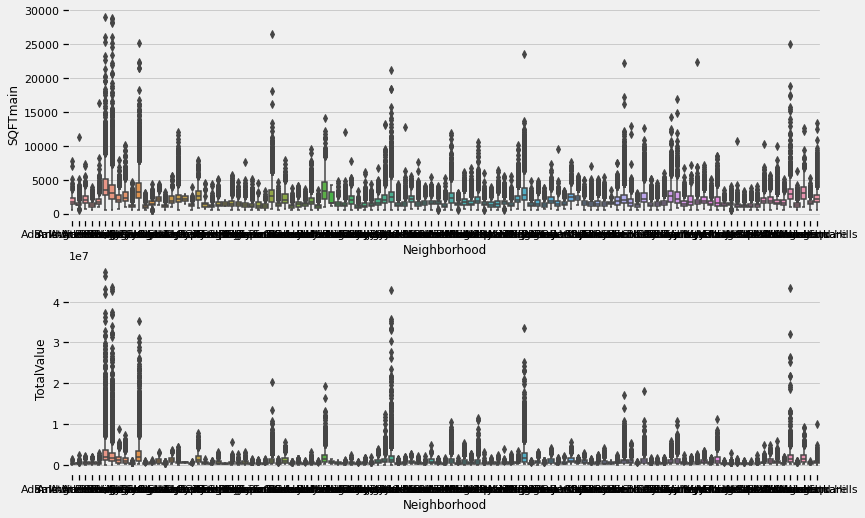

In [161]:
# Find a feature that can help distinguish between richer and "poorer" neighborhoods
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

sns.boxplot(x='Neighborhood', y='SQFTmain', data=train.sort_values('Neighborhood'), ax=axs[0])
sns.boxplot(x='Neighborhood', y='TotalValue', data=train.sort_values('Neighborhood'), ax=axs[1])
plt.show

In [162]:
train[['Neighborhood', 'TotalValue']].groupby('Neighborhood').median().sort_values(by = 'TotalValue', ascending = False).iloc[0:5]

,TotalValue
Neighborhood,
Bel-Air,1975436.0
Brentwood,1821960.0
Pacific Palisades,1603932.0
Beverly Crest,1576767.0
Westwood,1509096.0


Find rich and poor neighborhoods.

In [163]:
def find_rich_neighborhoods(data, n = 10, metric=np.median):
    """
    Find wealthy neighborhoods based on the median TotalValue of a residential property.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'TotalValue']]                # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
        .sort_values(by = 'TotalValue', ascending = False)  # Sort values by descending sale price
        .iloc[:n]                                           # Find the top n number of most expensive neighborhoods
        .index.to_list()                                    # Create a list of the names of the top most expensive neighborhoods
    )
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train)

# Print rich neighborhoods
print('The rich neighborhoods are: {}'.format(rich_neighborhoods))

The rich neighborhoods are: ['Bel-Air', 'Brentwood', 'Pacific Palisades', 'Beverly Crest', 'Westwood', 'Hancock Park', 'Windsor Square', 'Hollywood Hills West', 'Cheviot Hills', 'Century City']


In [164]:
def find_poor_neighborhoods(data, n = 10, metric=np.median):
    """
    Find poor neighborhoods based on the median TotalValue of a residential property.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'TotalValue']]                # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
        .sort_values(by = 'TotalValue')                     # Sort values by ascending sale price
        .iloc[:n]                                           # Find the top n number of most expensive neighborhoods
        .index.to_list()                                    # Create a list of the names of the top most expensive neighborhoods
    )
    
    return neighborhoods

# Find poor neighborhoods
poor_neighborhoods = find_poor_neighborhoods(train)

# Print poor neighborhoods
print('The poor neighborhoods are: {}'.format(poor_neighborhoods))

The poor neighborhoods are: ['Florence', 'Broadway-Manchester', 'Central-Alameda', 'Vermont-Slauson', 'Boyle Heights', 'Green Meadows', 'Cypress Park', 'Historic South-Central', 'Watts', 'Vermont Vista']


In [165]:
def add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood'
      rich_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
      poor_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as poor
    Output:
      data frame identical to the input with the addition of two binary
      in_rich_neighborhood and in_poor_neighborhood columns
    """
    data_copy = data.copy()
    
    # Write your code here.
    data_copy['in_rich_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(rich_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    data_copy['in_poor_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(poor_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    return data_copy

# Add 'in_rich_neighborhood' feature
training_data = add_in_neighborhoods(training_data, rich_neighborhoods, poor_neighborhoods)

# View DataFrame
training_data.head()

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,BusBenchClosestDist,...,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,TotalValue_median,in_rich_neighborhood,in_poor_neighborhood
0,1324.0,3,1,206319.0,1992,294033.0,1951,1953,13,3011.318639,...,2,0,0,0,1953.0,1957.0,1363.5,379852.0,0,0
1,2437.0,4,3,258766.0,2012,398010.0,2004,2004,13,907.934878,...,2,0,0,0,1953.0,1957.0,1363.5,379852.0,0,0
2,2177.0,4,2,86702.0,1996,280070.0,1953,1962,13,1079.369223,...,2,1,0,0,1953.0,1957.0,1363.5,379852.0,0,0
3,1150.0,3,2,200746.0,1989,355975.0,1953,1958,13,2522.116667,...,2,0,0,0,1953.0,1957.0,1363.5,379852.0,0,0
4,2591.0,3,3,111812.0,1987,279542.0,1982,1982,13,712.324839,...,2,0,0,0,1953.0,1957.0,1363.5,379852.0,0,0


One hot encode the TaxRateArea

In [166]:
taxrate_categories = data['TaxRateArea'].unique()

def ohe_taxratearea(data):
    """
    One-hot-encodes Tax Rate Area.
    New columns are of the form TaxRateArea_AREA
    """
    # List categories
    categories = taxrate_categories

    category_type = pd.CategoricalDtype(categories=categories)
    data['TaxRateArea'] = data['TaxRateArea'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='TaxRateArea',
                          columns=['TaxRateArea'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_taxratearea(training_data)
training_data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,BusBenchClosestDist,SubwayStopClosestDist,...,TaxRateArea_13245,TaxRateArea_372,TaxRateArea_21,TaxRateArea_482,TaxRateArea_497,TaxRateArea_20,TaxRateArea_308,TaxRateArea_470,TaxRateArea_484,TaxRateArea_13811
0,1324.0,3,1,206319.0,1992,294033.0,1951,1953,3011.318639,42148.021493,...,0,0,0,0,0,0,0,0,0,0
1,2437.0,4,3,258766.0,2012,398010.0,2004,2004,907.934878,39655.674348,...,0,0,0,0,0,0,0,0,0,0
2,2177.0,4,2,86702.0,1996,280070.0,1953,1962,1079.369223,36602.424545,...,0,0,0,0,0,0,0,0,0,0
3,1150.0,3,2,200746.0,1989,355975.0,1953,1958,2522.116667,39743.235617,...,0,0,0,0,0,0,0,0,0,0
4,2591.0,3,3,111812.0,1987,279542.0,1982,1982,712.324839,36972.849548,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307954,1852.0,3,2,210733.0,1992,351215.0,1963,1963,5652.434321,37966.577488,...,0,0,0,0,0,0,0,0,0,0
307955,1120.0,3,2,258919.0,2001,323640.0,1962,1962,6082.587754,38093.711517,...,0,0,0,0,0,0,0,0,0,0
307956,2184.0,2,2,442937.0,2019,608033.0,1985,1985,8273.078435,90857.444817,...,0,0,0,0,0,0,0,0,0,0
307957,1402.0,2,2,139200.0,2001,330708.0,1928,1950,8105.679242,90597.661938,...,0,0,0,0,0,0,0,0,0,0


In [167]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [168]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307959 entries, 0 to 307958
Columns: 141 entries, SQFTmain to TaxRateArea_13811
dtypes: float64(11), int32(3), int64(7), object(1), uint8(119)
memory usage: 85.5+ MB


In [169]:
def process_data(data):
    """Combine all pipelines to create processed data."""
    # One-hot-encode PropertyUseCode feature
    data = ohe_pusecode(data)
    
    # One-hot-encode TaxRateArea feature
    data = ohe_taxratearea(data)
    
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Add in the rich and poor neighborhoods
    data = add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandValue',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'TotalValue_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811',
                         'cluster'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

    Copy of all features considered for use:
    
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandValue',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'TotalValue_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811',
                         'cluster'
                         )

In [170]:
X_train, y_train = process_data(train)
    
X_train.head()

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,YearBuilt,EffectiveYearBuilt,ShapeSTAre,ShapeSTLen,crime_count,...,TaxRateArea_372,TaxRateArea_21,TaxRateArea_482,TaxRateArea_497,TaxRateArea_20,TaxRateArea_308,TaxRateArea_470,TaxRateArea_484,TaxRateArea_13811,cluster
0,1324.0,3,1,206319.0,1992,1951,1953,6323.622070,329.206820,1640,...,0,0,0,0,0,0,0,0,0,4
1,2437.0,4,3,258766.0,2012,2004,2004,4478.868164,303.993510,1640,...,0,0,0,0,0,0,0,0,0,4
2,2177.0,4,2,86702.0,1996,1953,1962,6451.202148,335.038766,1640,...,0,0,0,0,0,0,0,0,0,4
3,1150.0,3,2,200746.0,1989,1953,1958,8792.053711,398.436391,1640,...,0,0,0,0,0,0,0,0,0,4
4,2591.0,3,3,111812.0,1987,1982,1982,5497.589844,313.388650,1640,...,0,0,0,0,0,0,0,0,0,4


## Create Linear Regression Model

Create a cross-validation function returning the root mse from all splits. Cannot stratify this KFold since the target values are unique float values.

In [171]:
def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)   # Split the data into 5 parts
    rmse_values = []                # Initialize the list of rmse values, to be populated
    
    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        
        # Fit model
        model.fit(X.iloc[train_index], y.iloc[train_index])   # Take four parts as the training set, iterated through all possibilities
        y_predicted = model.predict(X.iloc[val_index])        # Take one part as the validation set
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))   # Append to empty list per iteration to populate the rmse values list
        
    return rmse_values

In [172]:
cv_scores = cross_validate_rmse(LinearRegression(), X_train, y_train)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(data['TotalValue'])

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [155704.0071616303, 238860.44417664508, 227450.35737422266, 229116.96290244246, 252874.76960997927]
Cross-validation RMSE scores mean: $220801.30824498396
Cross-validation RMSE scores std: $33781.23114858901
Mean Home Price: $669181.5503884603
RMSE Accuracy Score: 67.0042743831164%


In [173]:
X_val, y_val = process_data(val)
cv_scores = cross_validate_rmse(LinearRegression(), X_val, y_val)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(data['TotalValue'])

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [137678.15067556186, 150089.2473181727, 186095.24057150522, 285239.46700755286, 207161.44688554094]
Cross-validation RMSE scores mean: $193252.71049166674
Cross-validation RMSE scores std: $52264.44671079683
Mean Home Price: $669181.5503884603
RMSE Accuracy Score: 71.12103428740923%


In [174]:
X_test, y_test = process_data(test)
cv_scores = cross_validate_rmse(LinearRegression(), X_test, y_test)
mean_RMSE_scores = np.mean(cv_scores)
mean_home_values = np.mean(data['TotalValue'])

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(mean_RMSE_scores))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean Home Price: ${}'.format(mean_home_values))
print('RMSE Accuracy Score: {}%'.format((1-mean_RMSE_scores/mean_home_values)*100))

Cross-validation RMSE scores: [130159.72975821886, 169113.40056108896, 217933.27639817965, 269314.1092763779, 234108.81625329956]
Cross-validation RMSE scores mean: $204125.86644943297
Cross-validation RMSE scores std: $49063.20616491443
Mean Home Price: $669181.5503884603
RMSE Accuracy Score: 69.49619033415703%
